# TIMM

## Data and Imports



1.   celebdf



In [1]:
!cp -r /content/drive/MyDrive/celebdf/test /content



2.   leonardo



In [4]:
!cp -r /content/drive/MyDrive/leonardo_preprocessed/test /content/leonardo

In [2]:
!cp /content/drive/MyDrive/convnext_ckpts/trained_only_on_celebdf_2/epoch_9_step_5000.pth /content/convnext_ckpt_celebdf_only_9_5000.pth
!cp /content/drive/MyDrive/fastvit_ckpts/trained_only_on_celebdf/epoch_10_step_15000.pth /content/fastvit_ckpt_celebdf_only_10_15000.pth

In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

### celebdf data load

In [5]:
import os
data_path = '/content/data'
for folder in ['test']:
  os.makedirs(os.path.join(data_path, folder), exist_ok = True)

In [6]:

from tqdm import tqdm

source_path = "/content"
mode = "test"
dest_real = os.path.join(data_path,mode, "real")
dest_fake = os.path.join(data_path,mode, "fake")
# make mode dirs
os.makedirs(dest_real, exist_ok = True)
os.makedirs(dest_fake, exist_ok = True)

dest_mode = os.path.join(source_path, mode)
for dest_zip in tqdm(os.listdir(dest_mode), desc=f"{str(mode)}", leave=False):
  dest_zip_file_path = os.path.join(dest_mode,dest_zip)
  if "real" in dest_zip:
    !unzip -q -j {dest_zip_file_path} -d {dest_real}
  elif "fake" in dest_zip:
    !unzip -q -j {dest_zip_file_path} -d {dest_fake}

### leonardo data load

In [ ]:
import os
data_path = '/content/data_leonardo'
for folder in ['test']:
  os.makedirs(os.path.join(data_path, folder), exist_ok = True)

In [28]:
os.makedirs(os.path.join(data_path, folder, "fake"), exist_ok = True)
!cp /content/leonardo/* /content/data_leonardo/test/fake/

## Predict

In [29]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import numpy as np

In [40]:
# data_dir = '/content/data/test'
data_dir = '/content/data_leonardo/test'
model_checkpoint = '/content/convnext_ckpt_celebdf_only_9_5000.pth'  # Replace with your model checkpoint path
# model_checkpoint = '/content/drive/MyDrive/fastvit_ckpts/trained_only_on_celebdf/epoch_10_step_15000.pth'  # Replace with your model checkpoint path
batch_size = 512

### Dataset and DataLoader for the test set

In [41]:
class ImageFolderWithFilenames(datasets.ImageFolder):
    def __getitem__(self, index):
        # This is the same as the original method, but we add the filename as an additional return value
        original_tuple = super(ImageFolderWithFilenames, self).__getitem__(index)
        path, _ = self.samples[index]
        filename = os.path.basename(path)
        return original_tuple + (filename,)

In [42]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolderWithFilenames(root=data_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


### Load the model

In [43]:
# Change to fastvit_s12
model = timm.create_model('convnext_base', pretrained=False, num_classes=1)
# model = timm.create_model('fastvit_s12', pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_checkpoint))

<All keys matched successfully>

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

### Prediction function

In [45]:
from tqdm import tqdm
def predict():
    sigmoid = nn.Sigmoid()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    all_filenames = []

    with torch.no_grad():
        for inputs, labels, filenames in tqdm(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = sigmoid(outputs).squeeze().cpu().numpy()
            all_probabilities.extend(probabilities)
            predictions = np.round(probabilities)
            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())
            all_filenames.extend(filenames)

    return all_predictions, all_labels , all_probabilities, all_filenames

### Predict

In [46]:
predictions, labels , probabilities, filenames = predict()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


In [47]:
# result_filename = "convnext_celebdf_only.txt"
# result_filename = "fastvit_celebdf_only.txt"
# result_filename = "fastvit_leonardo_only.txt"
result_filename = "convnext_leonardo_only.txt"
with open(result_filename, mode="w") as f:
  for i, (pred, label, prob, fname) in enumerate(zip(predictions, labels , probabilities, filenames)):
    f.writelines(f'{fname} {pred} {label} {prob}\n')

In [48]:
# !cp /content/convnext_celebdf_only.txt /content/drive/MyDrive/convnext_celebdf_only.txt
# !cp /content/fastvit_celebdf_only.txt /content/drive/MyDrive/fastvit_celebdf_only.txt
# !cp /content/fastvit_leonardo_only.txt /content/drive/MyDrive/fastvit_leonardo_only.txt
!cp /content/convnext_leonardo_only.txt /content/drive/MyDrive/convnext_leonardo_only.txt

# YOLO

In [49]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 15.7 MB/s eta 0:00:00


In [50]:
!cp /content/drive/MyDrive/yolo_runs/yolo_trained_on_celebdf_only/train_3/train/weights/best.pt /content

In [51]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import yaml
from ultralytics import YOLO

# Parameters
# data_dir = '/content/data/test'
data_dir = '/content/data_leonardo/test'
model_checkpoint = '/content/best.pt'
# result_filename = "yolo_celebdf_only.txt"
result_filename = "yolo_leonardo_only.txt"

In [52]:
from tqdm import tqdm

model = YOLO(model_checkpoint)


with open(result_filename, mode="w") as f:
    for label_name in os.listdir(data_dir):
      label_path = os.path.join(data_dir, label_name)
      for image_name in tqdm(os.listdir(label_path)):
        image_path = os.path.join(data_dir, label_name, image_name)
        results = model(image_path,verbose=False)
        pred = results[0].probs.top1
        prob = results[0].probs.top1conf.cpu().numpy()
        reversed_names = {v: k for k, v in results[0].names.items()}
        label = reversed_names[label_name]
        fname = image_name
        f.writelines(f'{fname} {pred} {label} {prob}\n')

100%|██████████| 192/192 [00:06<00:00, 29.40it/s]


In [53]:
# !cp /content/yolo_celebdf_only.txt /content/drive/MyDrive
!cp /content/yolo_leonardo_only.txt /content/drive/MyDrive

# Plot

Accuracy: 0.8587
Recall: 0.8068
Precision: 0.9698
F1 Score: 0.8808


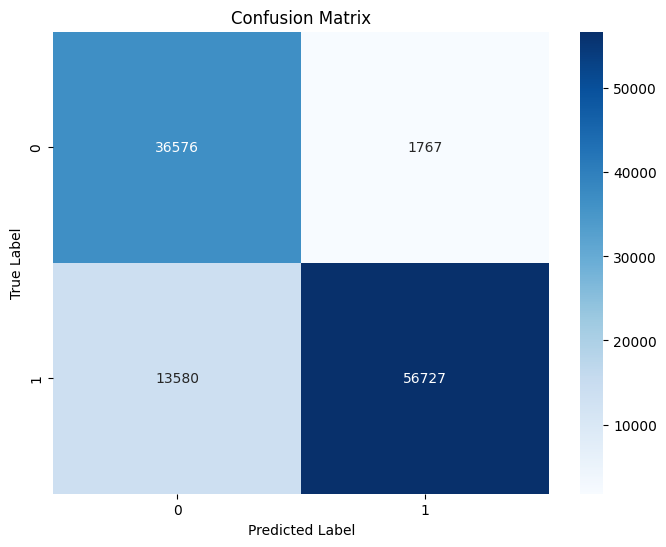

Accuracy: 0.7193
Recall: 0.6073
Precision: 0.9365
F1 Score: 0.7368


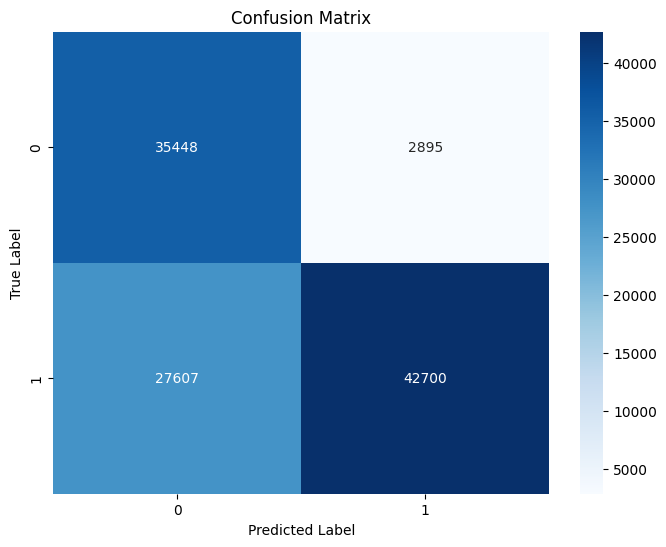

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.0000
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000


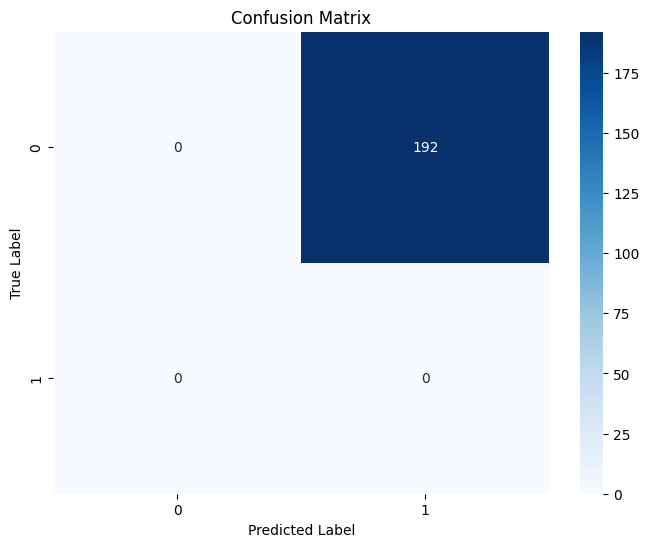

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.0000
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000


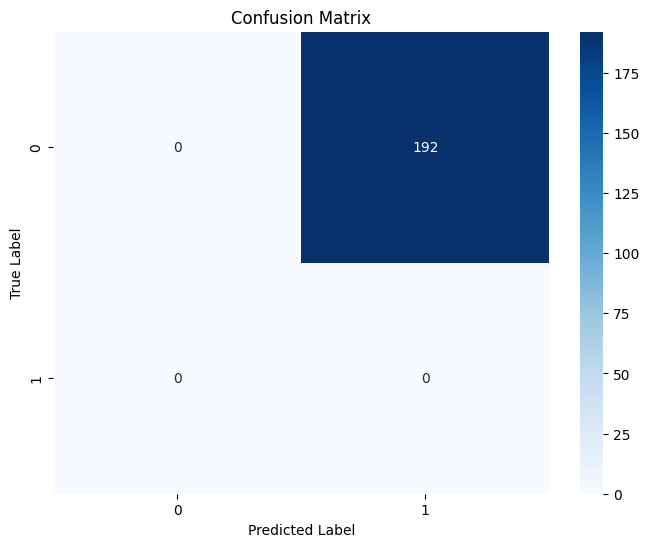

Accuracy: 0.9822
Recall: 0.9736
Precision: 0.9988
F1 Score: 0.9861


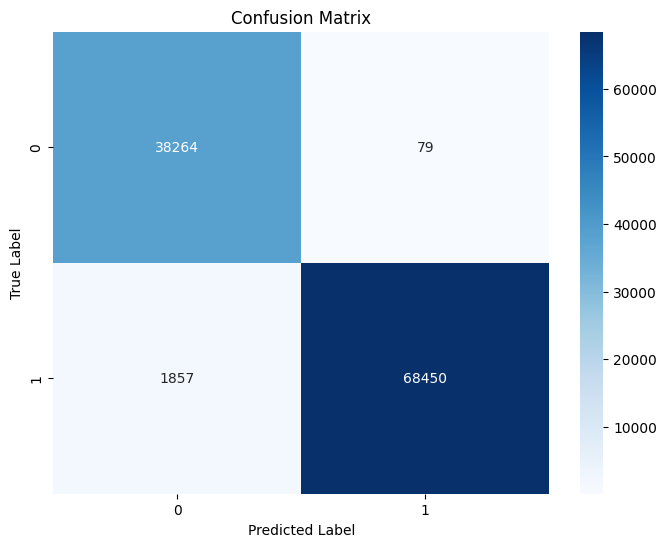

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.0000
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000


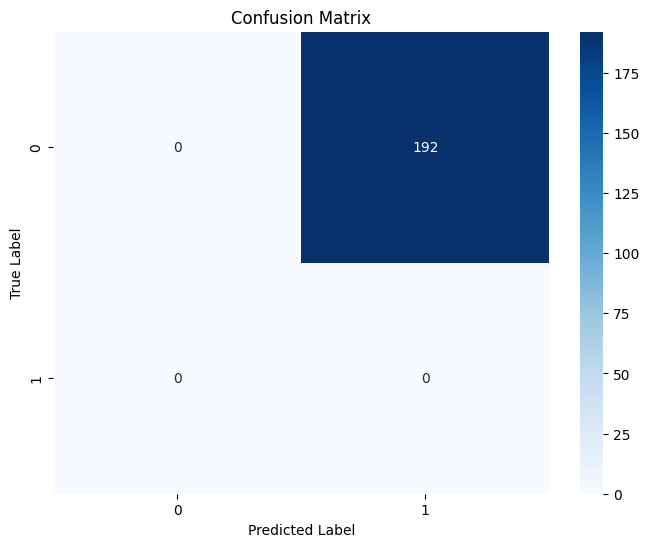

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Parameters
predictions_files = [
  '/content/drive/MyDrive/convnext_celebdf_only.txt',
  '/content/drive/MyDrive/fastvit_celebdf_only.txt',
  '/content/drive/MyDrive/convnext_leonardo_only.txt',
  '/content/drive/MyDrive/fastvit_leonardo_only.txt',
  '/content/drive/MyDrive/yolo_celebdf_only.txt',
  '/content/drive/MyDrive/yolo_leonardo_only.txt'
]

for predictions_file in predictions_files:
  metrics_output_name = predictions_file.split('/')[-1].replace(".txt","")
  metrics_output_file = f'{metrics_output_name}.json'

  # Read predictions from the text file
  filenames = []
  predictions = []
  labels = []
  probabilities = []

  with open(predictions_file, 'r') as file:
      lines = file.readlines()
      for line in lines:
          parts = line.strip().split()
          filenames.append(parts[0])
          predictions.append(int(float(parts[1])))
          # if "leonardo" in metrics_output_name:
          #   labels.append(1 - int(parts[2]))
          # else:
          labels.append(int(parts[2]))
          probabilities.append(float(parts[3]))

  # Convert lists to numpy arrays
  predictions = np.array(predictions)
  labels = np.array(labels)

  # Calculate metrics
  accuracy = accuracy_score(labels, predictions)
  recall = recall_score(labels, predictions)
  precision = precision_score(labels, predictions)
  f1 = f1_score(labels, predictions)

  # Print metrics
  print(f'Accuracy: {accuracy:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'F1 Score: {f1:.4f}')

  # Save metrics to JSON file
  metrics = {
      'accuracy': accuracy,
      'recall': recall,
      'precision': precision,
      'f1_score': f1
  }

  with open(metrics_output_file, 'w') as json_file:
      json.dump(metrics, json_file)

  # Plot confusion matrix
  conf_matrix = confusion_matrix(labels, predictions)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.savefig(f'{metrics_output_name}.png')
  plt.show()


In [57]:
!mkdir /content/drive/MyDrive/train_on_celebdf_only_results

In [71]:
!cp /content/*.png /content/drive/MyDrive/train_on_celebdf_only_results/
!cp /content/*.json /content/drive/MyDrive/train_on_celebdf_only_results/

In [69]:
for item in os.listdir("/content/data/test/fake"):
  print(item)
  break

id21_id19_0009__d1cf6aba.png
